In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import shap


In [2]:
# Load the dataset
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

# Display the first few rows
df.head()


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [3]:
# Inspect the dataset
df.info()  # Shows data types and missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


# EDA

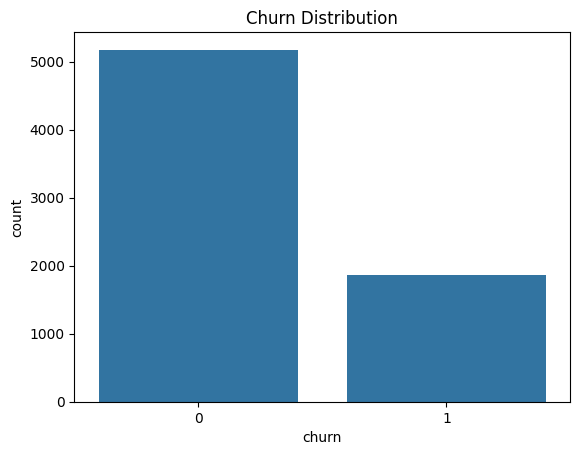

In [4]:
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution')
plt.show()


C:\Users\agnip\AppData\Local\Temp\ipykernel_20740\1108091065.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


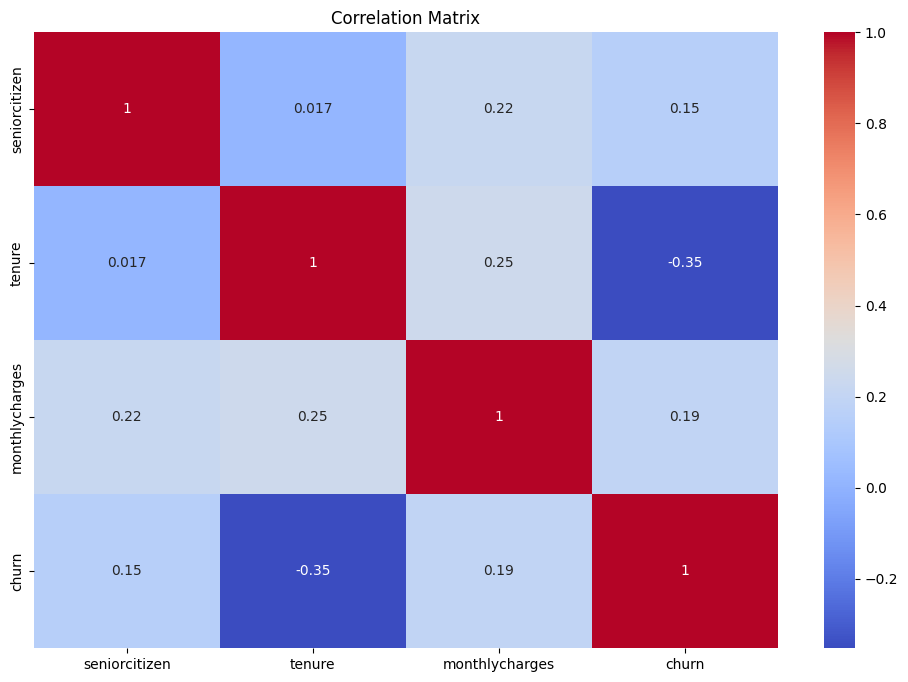

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


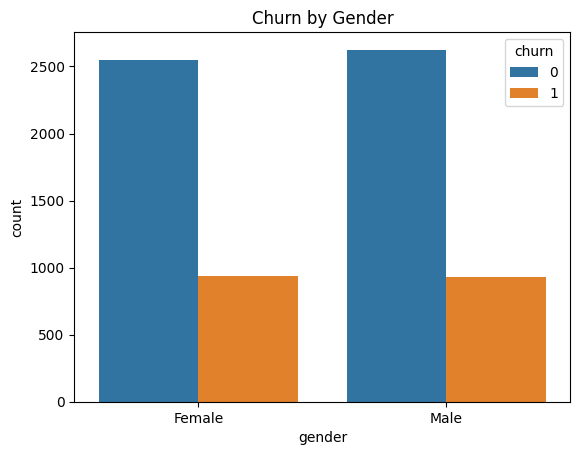

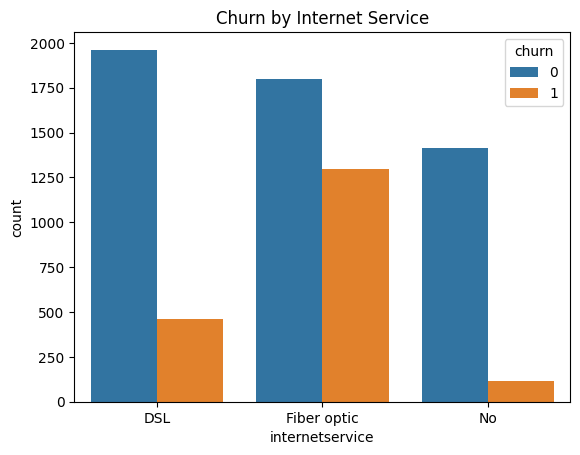

In [6]:
# Plot churn distribution by gender
sns.countplot(x='gender', hue='churn', data=df)
plt.title('Churn by Gender')
plt.show()

# Plot churn distribution by internet service
sns.countplot(x='internetservice', hue='churn', data=df)
plt.title('Churn by Internet Service')
plt.show()


# Data preprocessing

In [7]:
# Check for missing values
df.isnull().sum()

# For now, drop rows with missing values (you could also fill them)
df.dropna(inplace=True)


In [8]:
df = pd.get_dummies(df, columns=[
    'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
    'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies', 'contract',
    'paperlessbilling', 'paymentmethod'
], drop_first=True)

In [9]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')

# Fill missing 'totalcharges' with 0 (or use other strategies)
df['totalcharges'].fillna(0, inplace=True)

# Drop the 'customerid' column as it's irrelevant
df.drop(columns=['customerid'], inplace=True)

# Feature Scaling

In [11]:
# Drop customerid, as it's irrelevant for the model
X = df.drop(columns=['churn'])
y = df['churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Model training


In [12]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)


In [13]:
# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.78708303761533
Confusion Matrix:
 [[943  93]
 [207 166]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.64      0.45      0.53       373

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.79      0.77      1409



# Model explainability

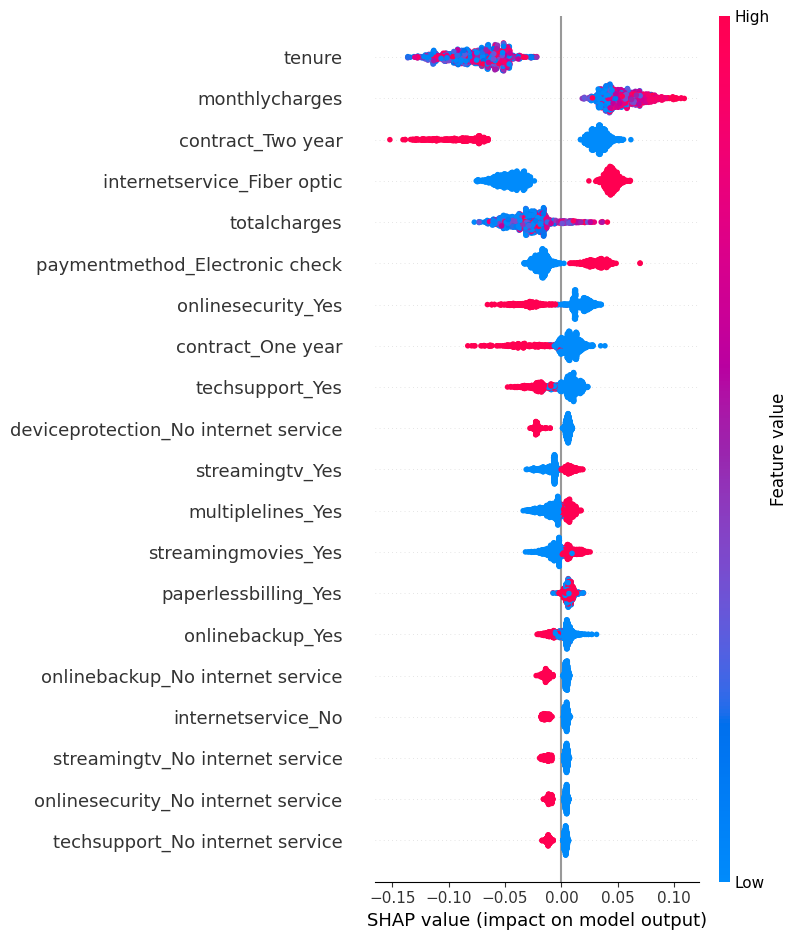

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:,:,1], X_test)

In [17]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

instance = X_test.iloc[0] 
explanation = explainer.explain_instance(instance.values, model.predict_proba)
explanation.show_in_notebook(show_table=True, show_all=False)


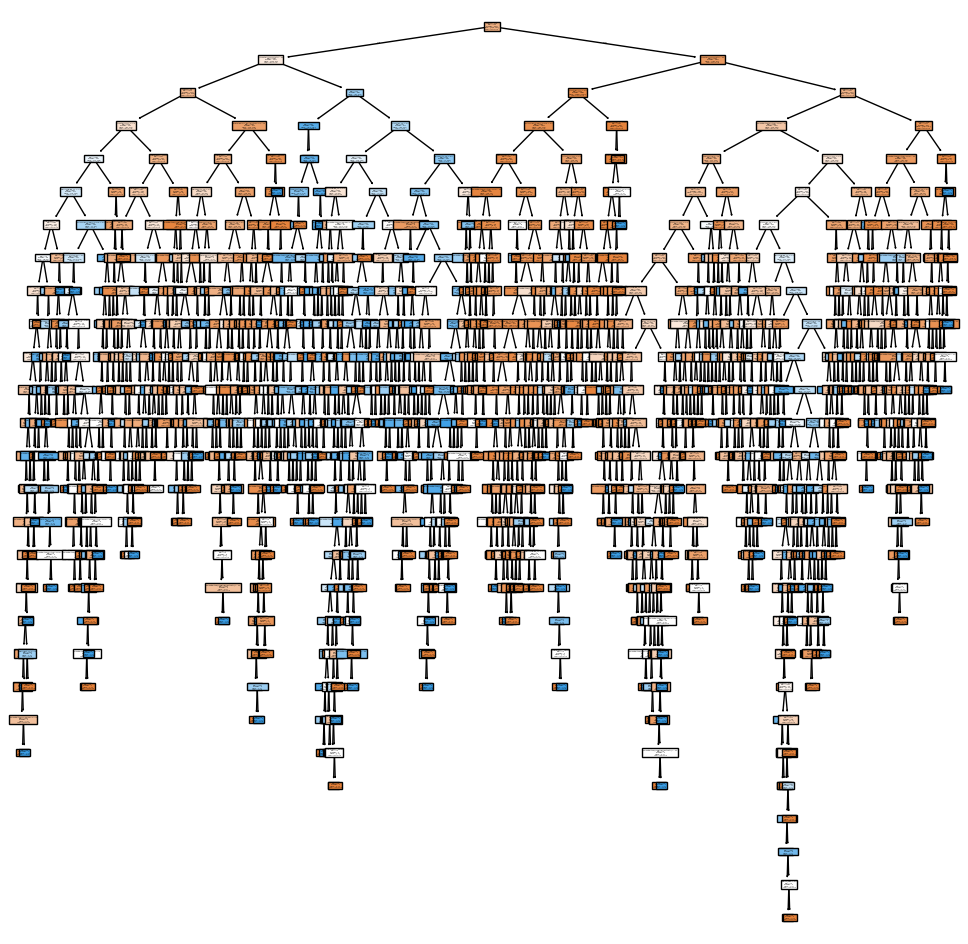

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Train a decision tree as a surrogate model
surrogate_model = DecisionTreeClassifier()
surrogate_model.fit(X_train, y_train)

# Plot the decision tree
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(surrogate_model, feature_names=X_train.columns, class_names=['Not Churn', 'Churn'], filled=True, ax=ax)
plt.show()
